## Matrix Factorization for Recommender System

MF can be used to **predict** ratings using _explicit feedback_. _Explicit feedback_ includes user ratings, while _implicit feedback_ could be user interactions with the items (clicks, views etc).

With MF, we decompose the original rating matrix `R` into two smaller matrices, user representation `U` and item representation `V`. The respective latent representation can then be used to build the reconstructed rating matrix `R_hat`.

This `R_hat` will contain the predicted ratings for those values that are initially 0.

In short, this method of ratings predictions requires the whole user-item ratings to be known, which can be expensive in real-world applications.

- U is the user matrix of shape (num users, K): where num users = |U|
- V is the item matrix of shape (num items, K): where num items = |V|
- Where K is the number of latent features of U and V
- R is the ground truth ratings matrix of shape (|U|, |V|)
- Finally, R_hat is the reconstructed ratings

## References
https://medium.com/@maxbrenner-ai/matrix-factorization-for-collaborative-filtering-linear-to-non-linear-models-in-python-5cf54363a03c

In [1]:
import matplotlib.pyplot as plt
import numpy as np

We train the model by minimizing the mean square error loss for every iteration:

$MSE = \frac{1}{N}\sum^N_{i=1}[R_i-\hat{R_i}]^2$

In order to calculate the loss, this cost function above must be differentiable:

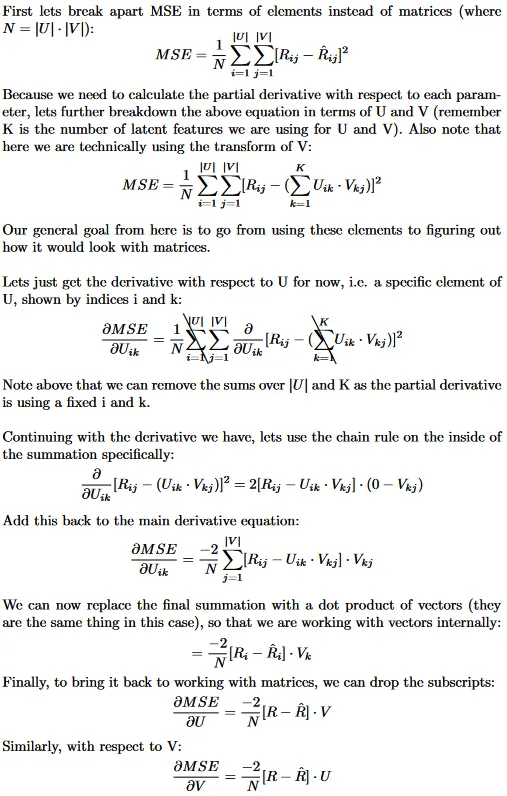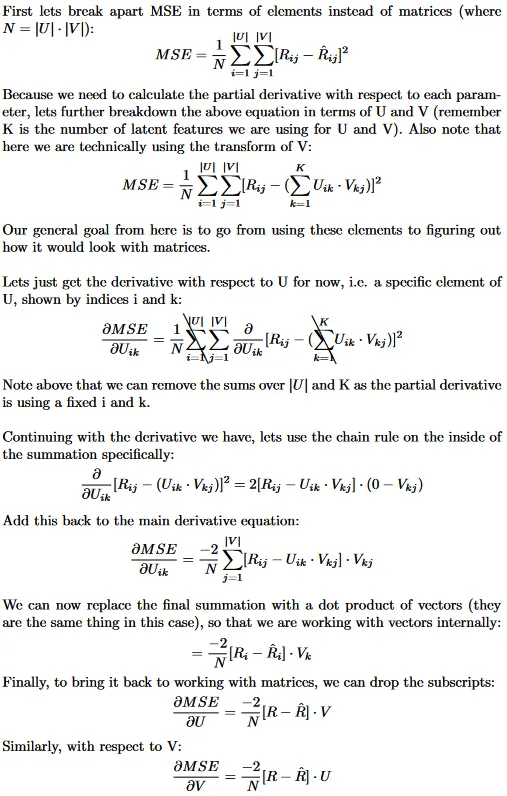


We can then update equation for `U` and `V`, where `alpha` is the learning rate:
    
$U = U - \alpha\frac{\partial\text{MSE}}{\partial\text{U}}$

$V = V - \alpha\frac{\partial\text{MSE}}{\partial\text{V}}$

In [2]:
def mean_squared_error(v):
    return np.square(error).mean()

In [3]:
R = np.array(
    [
        [5, 3, 0, 1],
        [4, 0, 0, 1],
        [1, 1, 0, 5],
        [1, 0, 0, 4],
        [0, 1, 5, 4],
    ],
    dtype=float,
)


n_user, n_item = R.shape
K = 3  # Latent factor size

# Initialize the U, V with random values.
# We will learn the values by training.
U = np.random.rand(n_user, K)
V = np.random.rand(n_item, K)
N = n_user * n_item

mse = []

T = 500  # Epochs
alpha = 0.1  # learning rate

for t in range(T):
    # Reconstruct the rating matrix.
    R_hat = U @ V.T
    mask = R > 0
    error = (R - R_hat) * mask

    U_grad = -2.0 / N * np.dot(error, V)
    V_grad = -2.0 / N * np.dot(error.T, U)

    U -= alpha * U_grad
    V -= alpha * V_grad

    # The loss should decrease over time.
    loss = mean_squared_error(error)
    mse.append(loss)
    if t % 100 == 0:
        print(t, loss)

0 4.70556079159327
100 0.011808767073942902
200 0.0009832284946307839
300 8.139397872204882e-05
400 6.675268642098761e-06


Text(0, 0.5, 'MSE')

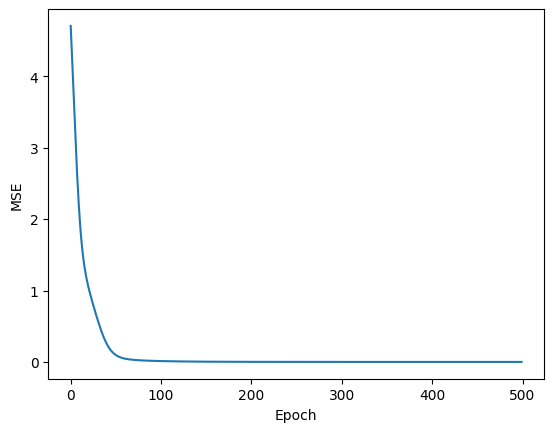

In [4]:
plt.plot(mse)
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [5]:
print("Original ratings:")
print(R)

Original ratings:
[[5. 3. 0. 1.]
 [4. 0. 0. 1.]
 [1. 1. 0. 5.]
 [1. 0. 0. 4.]
 [0. 1. 5. 4.]]


### Reconstructed Ratings

In [6]:
R_hat = U @ V.T
print(np.round(R_hat, 2))

[[5.   3.   3.57 1.  ]
 [4.   2.41 2.85 1.  ]
 [1.   1.   4.73 5.  ]
 [1.   0.91 3.92 4.  ]
 [1.12 1.   5.   4.  ]]


### Output

In [7]:
# If the replace does not work, check if the data type for R matches R_hat, which is float.
# If the data type of the matrix to replace does not match, it will silently failed.
mask = R == 0
R[mask] = R_hat[mask]
np.maximum(np.round(R, 1), 0)

array([[5. , 3. , 3.6, 1. ],
       [4. , 2.4, 2.8, 1. ],
       [1. , 1. , 4.7, 5. ],
       [1. , 0.9, 3.9, 4. ],
       [1.1, 1. , 5. , 4. ]])

## Using Keras

In TensorFlow 2.x, you can use `tf.GradientTape` to automatically compute the gradients for a matrix factorization model with mean squared error loss. Here's an example:

In this example, we first initialize user and item embedding matrices `U` and `V`. We then define a mean squared error loss function `mse_loss`, which computes the prediction matrix as the matrix product of `U` and `V`, and then computes the squared difference between the prediction matrix and the actual ratings matrix `R`. The loss is only computed for the non-zero entries of `R`.

We then use `tf.GradientTape` to compute the gradients of the loss with respect to the embedding matrices, and use the optimizer to apply these gradients. This is done in a loop for a fixed number of iterations.

In [8]:
import tensorflow as tf

R = tf.constant(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=tf.float32,
)
n_user, n_item = R.shape
N = n_user * n_item
K = 3

U = tf.Variable(tf.random.normal([n_user, K], stddev=0.1))
V = tf.Variable(tf.random.normal([n_item, K], stddev=0.1))

T = 500  # Epochs
alpha = 0.01  # Learning rate

losses = []
trainable_weights = [U, V]
optimizer = tf.keras.optimizers.SGD(learning_rate=alpha)

# Define the loss function
def mse_loss(U, V, R):
    R_hat = tf.matmul(U, V, transpose_b=True)
    # return tf.keras.metrics.mean_squared_error(R, R_hat)
    non_zero_mask = tf.math.not_equal(R, 0)
    loss = tf.reduce_sum(tf.square(R - R_hat) * tf.cast(non_zero_mask, tf.float32))
    return loss


for t in range(T):
    with tf.GradientTape() as tape:
        # We rely on automatic differentiation to calculate the gradient loss.
        loss = mse_loss(U, V, R)
    grads = tape.gradient(loss, trainable_weights)
    optimizer.apply_gradients(zip(grads, trainable_weights))
    losses.append(tf.reduce_mean(loss).numpy())

    if t % 100 == 0:
        print(t, tf.reduce_mean(loss).numpy())

2024-01-29 02:25:23.330342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0 138.54195
100 0.10366656
200 0.0022950678
300 4.9743063e-05
400 1.0735715e-06


Text(0, 0.5, 'MSE')

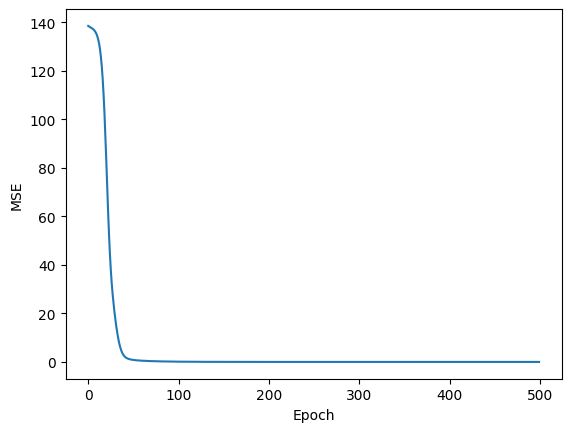

In [9]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE")

In [10]:
R_hat = tf.matmul(U, V, transpose_b=True).numpy()
R = R.numpy()
R

array([[5., 3., 0., 1.],
       [4., 0., 0., 1.],
       [1., 1., 0., 5.],
       [1., 0., 0., 4.],
       [0., 1., 5., 4.]], dtype=float32)

### Reconstructed Ratings

In [11]:
np.round(R_hat, 2)

array([[5.  , 3.  , 3.87, 1.  ],
       [4.  , 2.42, 3.27, 1.  ],
       [1.  , 1.  , 5.81, 5.  ],
       [1.  , 0.92, 4.77, 4.  ],
       [1.17, 1.  , 5.  , 4.  ]], dtype=float32)

In [12]:
mask = R == 0
R[mask] = R_hat[mask]
np.round(R, 1)

array([[5. , 3. , 3.9, 1. ],
       [4. , 2.4, 3.3, 1. ],
       [1. , 1. , 5.8, 5. ],
       [1. , 0.9, 4.8, 4. ],
       [1.2, 1. , 5. , 4. ]], dtype=float32)

### Output

In [13]:
# We still have issue with negative values, and some values goes beyond 5.
np.round(np.clip(R, 0, 5), 1)

array([[5. , 3. , 3.9, 1. ],
       [4. , 2.4, 3.3, 1. ],
       [1. , 1. , 5. , 5. ],
       [1. , 0.9, 4.8, 4. ],
       [1.2, 1. , 5. , 4. ]], dtype=float32)

The output should match the one done with numpy.

## Using Keras, skipping ratings

In [14]:
import numpy as np
import tensorflow as tf

# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Get the number of users and items
num_users, num_items = R.shape

# Get the indices of non-zero entries
user_ids, item_ids = np.nonzero(R)

# Get the corresponding ratings
ratings = R[user_ids, item_ids]

# Define the embedding dimension
embedding_dim = 2

# Initialize user and item embedding matrices
U = tf.Variable(tf.random.normal((num_users, embedding_dim)))
V = tf.Variable(tf.random.normal((num_items, embedding_dim)))

# Define the learning rate
lr = 0.01

# Define the number of epochs
epochs = 1000

# Define the optimizer
optimizer = tf.optimizers.SGD(lr)
losses = []
# Run the optimization
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        # Compute the dot product between the user and item embeddings
        prediction = tf.reduce_sum(
            tf.gather(U, user_ids) * tf.gather(V, item_ids), axis=1
        )

        # Compute the mean squared error loss
        loss = tf.reduce_mean((ratings - prediction) ** 2)

    # Compute the gradients
    grads = tape.gradient(loss, [U, V])

    # Apply the gradients
    optimizer.apply_gradients(zip(grads, [U, V]))
    if epoch % 100 == 0:
        print("Epoch", epoch, "Loss", loss.numpy())
    losses.append(loss.numpy())

Epoch 0 Loss 11.964392
Epoch 100 Loss 2.9976656
Epoch 200 Loss 1.3327167
Epoch 300 Loss 0.74805963
Epoch 400 Loss 0.47322863
Epoch 500 Loss 0.37248442
Epoch 600 Loss 0.32749748
Epoch 700 Loss 0.29978654
Epoch 800 Loss 0.27842447
Epoch 900 Loss 0.2598317


### Reconstructed ratings

In [15]:
np.round(U.numpy() @ V.numpy().T, 2)

array([[ 5.21,  1.77,  5.71,  1.17],
       [ 3.9 ,  1.33,  4.15,  1.05],
       [ 1.08,  0.54, -2.22,  5.07],
       [ 0.99,  0.48, -1.59,  4.01],
       [ 5.99,  2.13,  4.84,  3.78]], dtype=float32)

## SGD

In [16]:
import numpy as np

# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Initialize user and item embedding matrices
num_users, num_items = R.shape
embedding_dim = 3
U = np.random.normal(size=(num_users, embedding_dim))
V = np.random.normal(size=(num_items, embedding_dim))

# Define the learning rate
lr = 0.01

# Define the number of epochs
epochs = 500
losses = []
# Run the optimization
for epoch in range(epochs):
    for i in range(num_users):
        for j in range(num_items):
            if R[i, j] > 0:  # only consider non-zero entries
                error = R[i, j] - np.dot(U[i, :], V[j, :])
                U[i, :] += lr * error * V[j, :]
                V[j, :] += lr * error * U[i, :]

    mse_loss = np.sum((R - np.dot(U, V.T)) ** 2) / np.sum(R > 0)
    if epoch % 100 == 0:

        print("Epoch", epoch, "MSE Loss", mse_loss)
    losses.append(mse_loss)

Epoch 0 MSE Loss 13.201222411046873
Epoch 100 MSE Loss 5.04649070597914
Epoch 200 MSE Loss 5.1267515619937
Epoch 300 MSE Loss 5.144876772348632
Epoch 400 MSE Loss 5.147223542088553


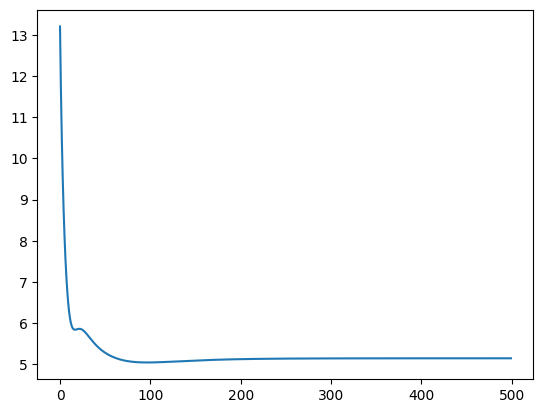

In [17]:
plt.plot(losses)

### Reconstructed Rating

In [18]:
np.round(U @ V.T, 2)

array([[ 5.  ,  3.  ,  4.08,  1.  ],
       [ 4.  ,  0.51,  2.89,  1.  ],
       [ 1.  ,  1.  ,  3.38,  5.  ],
       [ 1.  , -1.49,  2.23,  4.  ],
       [ 4.81,  1.  ,  5.  ,  4.  ]])

In [19]:
R

array([[5., 3., 0., 1.],
       [4., 0., 0., 1.],
       [1., 1., 0., 5.],
       [1., 0., 0., 4.],
       [0., 1., 5., 4.]], dtype=float32)

## Tensorflow

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Assume we have some ratings matrix R
R = np.array(
    [[5, 3, 0, 1], [4, 0, 0, 1], [1, 1, 0, 5], [1, 0, 0, 4], [0, 1, 5, 4]],
    dtype=np.float32,
)

# Get the number of users and items
num_users, num_items = R.shape

# Get the indices of non-zero entries
user_ids, item_ids = np.nonzero(R)

# Get the corresponding ratings
ratings = R[user_ids, item_ids]

# Define the embedding dimension
embedding_dim = 2

# Define the inputs
user_input = Input(shape=(1,), dtype=tf.int32)
item_input = Input(shape=(1,), dtype=tf.int32)

# Define the user and item embeddings
user_embedding = Embedding(
    input_dim=num_users, output_dim=embedding_dim, name="user_embeddings"
)(user_input)
item_embedding = Embedding(
    input_dim=num_items, output_dim=embedding_dim, name="item_embeddings"
)(item_input)

# Flatten the embeddings
user_embedding = Flatten()(user_embedding)
item_embedding = Flatten()(item_embedding)

# Compute the dot product between the user and item embeddings
rating_prediction = tf.reduce_sum(user_embedding * item_embedding, axis=1)

# Define the model
model = Model(inputs=[user_input, item_input], outputs=rating_prediction)

# Compile the model
model.compile(loss="mean_squared_error", optimizer=Adam())

# Fit the model
model.fit([user_ids, item_ids], ratings, epochs=1000, verbose=0)

In [21]:
# Assume we want to predict the rating for the first user and the first item
user_id = np.array([0])
item_id = np.array([0])

# Predict the rating
predicted_rating = model.predict([user_id, item_id])

print("Predicted rating:", predicted_rating[0])

1/1 [==============================] - 0s 108ms/step
Predicted rating: 2.769709


### Reconstructed Rating

In [22]:
# Get the user and item embeddings
user_embeddings = model.get_layer(name="user_embeddings").get_weights()[0]
item_embeddings = model.get_layer(name="item_embeddings").get_weights()[0]

# Compute the dot product between the user and item embeddings
predicted_ratings = user_embeddings @ item_embeddings.T

print("Predicted ratings matrix:")
print(np.round(predicted_ratings, 2))

Predicted ratings matrix:
[[2.77 1.83 3.27 2.94]
 [2.29 1.51 2.7  2.43]
 [2.51 1.66 2.97 2.66]
 [2.42 1.6  2.86 2.57]
 [2.85 1.89 3.37 3.03]]


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 user_embeddings (Embedding  (None, 1, 2)                 10        ['input_1[0][0]']             
 )                                                                                                
                                                                                                  
 item_embeddings (Embedding  (None, 1, 2)                 8         ['input_2[0][0]']         